In [187]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [335]:
df = pd.read_csv("cleaned_2014", low_memory = False);

In [412]:
df.tail()

,funded_amnt,int_rate,total_pymnt,annual_inc,dti,loan_status,revol_util,term,emp_length_1 year,emp_length_10+ years,...,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,amnt,paid
218511,0.511765,0.1447,25188.225984,0.014272,0.496374,Fully Paid,0.776,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18400.0,0
218512,0.617647,0.1997,4680.000000,0.010004,0.461365,Charged Off,0.463,5.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22000.0,1
218513,0.579412,0.1699,30573.222000,0.005736,0.641410,Fully Paid,0.511,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20700.0,0
218514,0.029412,0.0790,2126.579838,0.010671,0.134784,Fully Paid,0.215,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000.0,0
218515,0.264706,0.1920,13232.503339,0.005736,0.569642,Fully Paid,0.708,3.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10000.0,0


In [525]:
data_train, data_test = train_test_split(df, test_size=.2, stratify=df.paid, random_state=1)

In [526]:
def split_data(df, cols):
    x = df.drop(cols, axis = 1)
    y = df.paid
    return x, y

cols_to_drop_training = ['loan_status', 'paid', 'amnt', 'total_pymnt', 'term']
x_train, y_train = split_data(data_train, cols_to_drop_training)
x_test, y_test = split_data(data_test, cols_to_drop_training)

In [528]:
x_train.shape

(174812, 48)

In [529]:
#create a function to take advantage of sklearn make_pipeline
#pipeline adds second order terms and interaction terms to X_train and then fits model
def rf_model(x, y, d):
    model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    RandomForestClassifier(max_depth = d, n_estimators = 100))
    model.fit(x, y)
    return model

rf_complex = rf_model(x_train, y_train, 10)

In [564]:
#create a function to take advantage of sklearn make_pipeline
#pipeline adds second order terms and interaction terms to X_train and then fits model
def logreg_model(x, y):
    model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LogisticRegressionCV(cv = 3, penalty = 'l2', max_iter = 10000))
    model.fit(x, y)
    return model

logreg_complex = logreg_model(x_train, y_train)

In [342]:
def create_df(data_1, data_2):
    df = pd.DataFrame(data_1)
    
    df['int_rate'] = data_2['int_rate']
    df['amnt'] = data_2['amnt']
    df['total_pymnt'] = data_2['total_pymnt']
    df['term'] = data_2['term']
    df['ROI'] = (df['int_rate'])*(1-df['proba'])

    df['Real_ROI'] = df['amnt']*(((df['total_pymnt']/df['amnt'])**(1/df['term']))-1)
    df['annualized_amnt'] = df['amnt']*(1/df['term'])
    
    return df

In [565]:
train_data = {'proba' : logreg_complex.predict_proba(x_train)[:, 1], 'true_val' : y_train}
test_data = {'proba' : logreg_complex.predict_proba(x_test)[:, 1], 'true_val' : y_test}

df_train = create_df(train_data, data_train)
df_test =  create_df(test_data, data_test)

In [566]:
df_train.tail()

,proba,true_val,int_rate,amnt,total_pymnt,term,ROI,Real_ROI,annualized_amnt
83628,0.291054,1,0.1499,25000.0,8665.200000,3.0,0.106271,-7438.853357,8333.333333
126233,0.077514,0,0.1167,8000.0,9517.899386,3.0,0.107654,476.964437,2666.666667
82002,0.335033,0,0.2020,19000.0,25489.593211,3.0,0.134323,1955.114371,6333.333333
7475,0.111427,0,0.1199,16000.0,19117.978743,3.0,0.106540,978.291273,5333.333333
77360,0.345679,0,0.1699,27425.0,31808.380000,5.0,0.111169,825.466207,5485.000000


In [596]:
baseline_train = np.mean(df_train.ROI)
baseline_test = np.mean(df_test.ROI)
print(baseline_train, baseline_test)
alpha_low = 0.5
alpha_high = 1

0.1059016444424917 0.10591492821042693


In [597]:
loans_to_buy_train = df_train[(df_train.ROI > alpha_low*baseline_train) & (df_train.ROI < alpha_high*baseline_train)]
loans_to_buy_test = df_test[(df_test.ROI > alpha_low*baseline_test) & (df_test.ROI < alpha_high*baseline_test)]

In [598]:
def return_performance(df_sub, df_main):
    perf_subset = np.sum(df_sub.Real_ROI)/np.sum(df_sub.annualized_amnt)
    perf_mainset = np.sum(df_main.Real_ROI)/np.sum(df_main.annualized_amnt)
    return (perf_subset, perf_mainset, perf_subset - perf_mainset)

In [599]:
training_set_performance = return_performance(loans_to_buy_train, df_train)
testing_set_performance = return_performance(loans_to_buy_test, df_test)

In [600]:
print(training_set_performance)
print(testing_set_performance)

(0.05649491585372523, 0.048889501414794555, 0.007605414438930674)
(0.05827890193768245, 0.049272700564121655, 0.009006201373560792)


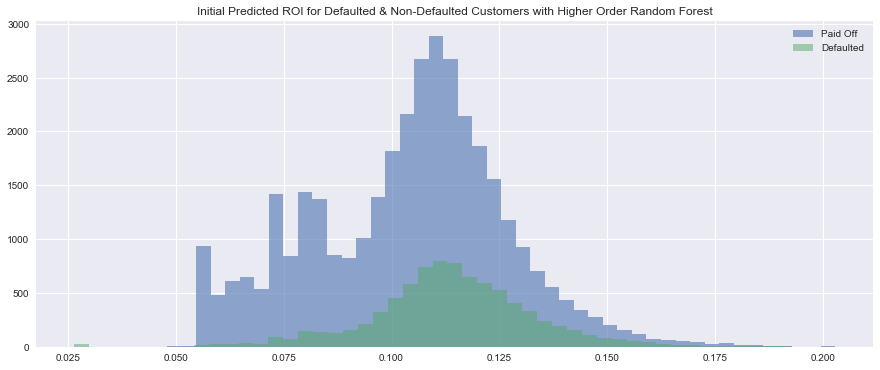

In [601]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);

ax.hist(df_test.loc[df_test.true_val == 0,'ROI'], bins = 50, label='Paid Off', alpha=0.6);
ax.hist(df_test.loc[df_test.true_val == 1,'ROI'], bins = 50, label='Defaulted', alpha=0.5);
ax.set_title('Initial Predicted ROI for Defaulted & Non-Defaulted Customers with Higher Order Random Forest')
ax.legend(loc='best')

plt.show()

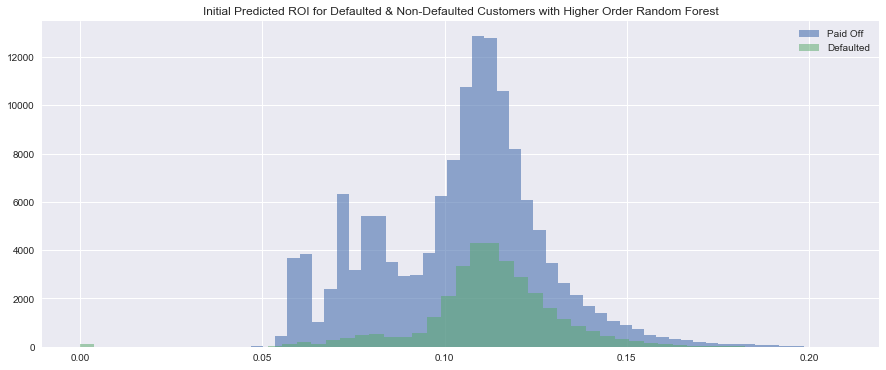

In [543]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);

ax.hist(df_train.loc[df_train.true_val == 0,'ROI'], bins = 50, label='Paid Off', alpha=0.6);
ax.hist(df_train.loc[df_train.true_val == 1,'ROI'], bins = 50, label='Defaulted', alpha=0.5);
ax.set_title('Initial Predicted ROI for Defaulted & Non-Defaulted Customers with Higher Order Random Forest')
ax.legend(loc='best')

plt.show()